In [1]:
import MDAnalysis as mda
from numpy import *
import os
from pylab import *
import MDAnalysis.analysis.distances
import MDAnalysis.analysis.rms
from MDAnalysis.analysis import align
import glob
#import umap
import scipy.stats
import sklearn
import sklearn.decomposition
import sklearn.preprocessing
import mdtraj
import pandas as pd
import seaborn as sns
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

In [2]:
EQPOINT=250



h2opath="data/water/solvent_included/"
pegpath="data/peg/solvent_included/"

#glob tprs
h2ogros=glob.glob(h2opath+"*.gro")
peggros=glob.glob(pegpath+"*.gro")

#glob tprs
h2otprs=glob.glob(h2opath+"*.tpr")
pegtprs=glob.glob(pegpath+"*.tpr")

#trjs
h2otrjs=glob.glob(h2opath+"*.xtc")
pegtrjs=glob.glob(pegpath+"*.xtc")

systemtprs=[h2otprs,pegtprs]
systemtrjs=[h2otrjs,pegtrjs]



resids_proper=list(arange(-4,67))+list(arange(69,238))
resids=list(arange(-4,67))+[nan,nan]+list(arange(69,238))
#get universes 
h2ou=[]
pegu=[]

for i in range(len(h2ogros)):
    h2ou.append(mda.Universe(h2otprs[i],h2otrjs[i]))
    #fix resids immediately
    h2ou[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
for i in range(len(peggros)):
    pegu.append(mda.Universe(pegtprs[i],pegtrjs[i]))
    #fix resids immediately
    pegu[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
    
    
#compile all the systems in one list
systems = [h2ou,pegu]
system_names = ['No-PEG','PEG']
#[]
#[tol-darkgreen,tol-darkblue,tol-bottompurple]
twoColour=["#332288","#882255"]
# Dark green,    
#sixColor=['#0A732D','#332288','#88CCEE',"#44AA99",'#882255','#D250BC']
#colorScheme=sixColor
colourScheme = twoColour
# Let's set up the selections for each trajectory by chain

# i want to make a list that has the sh2 domains selected in each sublist so that each one has 6 selections.
h2ou_fullprotein=[]
pegu_fullprotein=[]

h2ou_fullprotein_string=[]
pegu_fullprotein_string=[]


h2ou_notail=[]
pegu_notail=[]


h2ou_notail_string=[]
pegu_notail_string=[]


for i in range(len(h2otrjs)):
    h2ou_notail.append(h2ou[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    h2ou_notail_string.append("(protein or resname CH6) and resid 1:228")
    h2ou_fullprotein.append(h2ou[i].select_atoms("(protein or resname CH6)"))
    h2ou_fullprotein_string.append("(protein or resname CH6)")
    
for i in range(len(pegtrjs)):
    pegu_notail.append(pegu[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    pegu_notail_string.append("(protein or resname CH6) and resid 1:228")
    pegu_fullprotein.append(pegu[i].select_atoms("(protein or resname CH6)"))
    pegu_fullprotein_string.append("(protein or resname CH6)")

fullprotein_selections=[h2ou_fullprotein,pegu_fullprotein]
fullprotein_selections_string=[h2ou_fullprotein_string,pegu_fullprotein_string]
notail_selections = [h2ou_notail,pegu_notail]
notail_selections_string = [h2ou_notail_string,pegu_notail_string]



In [3]:
def getHBondDataFrame(tpr,trj,systemname=None,trajectorynumber=None):
    u=mda.Universe(tpr,trj,updating = True)
    p=u.select_atoms("protein or resname CH6") #need to explicitly include non standard residue names in this statement
    p.residues.resids = resids_proper

    hba1=HBA(u,between = ["resname CH6","protein or resname CH6"],d_a_cutoff =3.5)

    hba1.hydrogens_sel = hba1.guess_hydrogens("all")
    hba1.acceptors_sel = hba1.guess_acceptors("all") #DO NOT GUESS DONORS IF YOU HAVE BOND INFORMATION (we do)

    results=hba1.run()
    df = pd.DataFrame(results.hbonds,columns=["frame","donorid","hid","acceptorid","distance","angle"])

    premap=[]
    for i in range(len(u.select_atoms("all").atoms)):
        premap.append((u.select_atoms("all").atoms.ids[i],u.select_atoms("all").atoms[i].residue.resid))
    residmap = dict(premap)
    
    premap=[]
    for i in range(len(u.select_atoms("all").atoms)):
        premap.append((u.select_atoms("all").atoms.ids[i],u.select_atoms("all").atoms[i].residue.resname))
    resnamemap = dict(premap)

    df["donor_resid"]=df["donorid"].apply(residmap.get)
    df["acceptor_resid"]=df["acceptorid"].apply(residmap.get)
    df["donor-acceptor"]=df["donor_resid"].astype(str)+"-"+df["acceptor_resid"].astype(str)

    df["acceptor_atomname"]=u.atoms.names[df.acceptorid.values.astype(int)]
    df["donor_atomname"]=u.atoms.names[df.donorid.values.astype(int)]
    df["h_atomname"]=u.atoms.names[df.hid.values.astype(int)]

    df["acceptor_resname"]=df["acceptorid"].apply(resnamemap.get)
    df["donor_resname"]=df["donorid"].apply(resnamemap.get)



    #Construct sets of atom ids bound to the donor and acceptor,
    #this will be used for coulomb energy  hbond energy calculation
    donorsets=[]
    acceptorsets=[]
    donorcharges=[]
    acceptorcharges=[]
    donorpositions=[]
    acceptorpositions=[]
    hbondenergies=[]
    for i in range(len(df)):
        # basically, it takes the donor hydrogen id, finds its bonds, 
        # gets all the atoms in the bonds (which should just be the donor and the hydrogen), then shows only unique IDs
        donorset=list(set(list(u.atoms[int(df.hid[i])].bonds.to_indices().flatten())))
        acceptorset=list(set(list(u.atoms[int(df.acceptorid[i])].bonds.to_indices().flatten())))

        donorcharge = u.atoms[donorset].charges
        acceptorcharge = u.atoms[acceptorset].charges

        donorpos = u.atoms[donorset].positions
        acceptorpos = u.atoms[acceptorset].positions

        donorsets.append(donorset)
        acceptorsets.append(acceptorset)
        donorcharges.append(donorcharge)
        acceptorcharges.append(acceptorcharge)
        donorpositions.append(donorpos)
        acceptorpositions.append(acceptorpos)

        hbondenergies.append(computeHydrogenBondEnergy(donorcharge,acceptorcharge,donorpos,acceptorpos,f=332))

    df["donorsets"] = donorsets
    df["donorcharges"] = donorcharges
    df["acceptorsets"] = acceptorsets
    df["acceptorcharges"] = acceptorcharges
    df["donorpositions"] = donorpositions
    df["acceptorpositions"] = acceptorpositions
    df["hbondenergies"] = hbondenergies

    return df

def computeHydrogenBondEnergy(donorcharge,acceptorcharge,donorpos,acceptorpos,f=332):
    E=0
    for i in range(len(donorcharge)):
        for j in range(len(acceptorcharge)):
            displacement = donorpos[i] - acceptorpos[j]
            r = sqrt(dot(displacement,displacement))
            E+=f*donorcharge[i]*acceptorcharge[j]/r
    return E

In [4]:
hbondDFs=[]


# The first time

for i in range(len(systemtprs)):
    subdfs=[]
    for j in range(len(systemtprs[i])):
        subdfs.append(getHBondDataFrame(systemtprs[i][j],systemtrjs[i][j],systemname=system_names[i],trajectorynumber=j+1))
    hbondDFs.append(subdfs)



/home/liam/.local/lib/python3.10/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:672: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)
/home/liam/.local/lib/python3.10/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:672: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)
/home/liam/.local/lib/python3.10/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:672: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)
/home/liam/.local/lib/python3.10/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysi

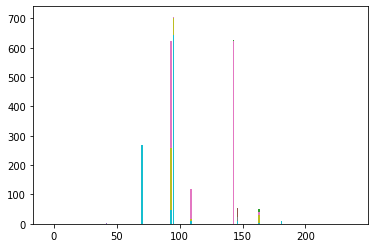

In [122]:
all_ch6_hb_propensities=[]

for i in range(len(hbondDFs)):
    sub=[]
    for j in range(len(hbondDFs[i])):

        tdf = hbondDFs[i][j]
        a=hist(tdf.donor_resid[tdf.frame > 250],bins = arange(-4.5,238.5,1))
        countbyRes = a[0]
        propensitybyRes = a[0]/(1000-EQPOINT)
        
        sub.append(propensitybyRes)
    all_ch6_hb_propensities.append(sub)

In [123]:
system_avg_ch6_hb_propensities=[]
system_sem_ch6_hb_propensities=[]

for i in range(len(all_ch6_hb_propensities)):
    system_avg_ch6_hb_propensities.append(mean(all_ch6_hb_propensities[i],axis = 0))
    system_sem_ch6_hb_propensities.append(scipy.stats.sem(all_ch6_hb_propensities[i],axis = 0))


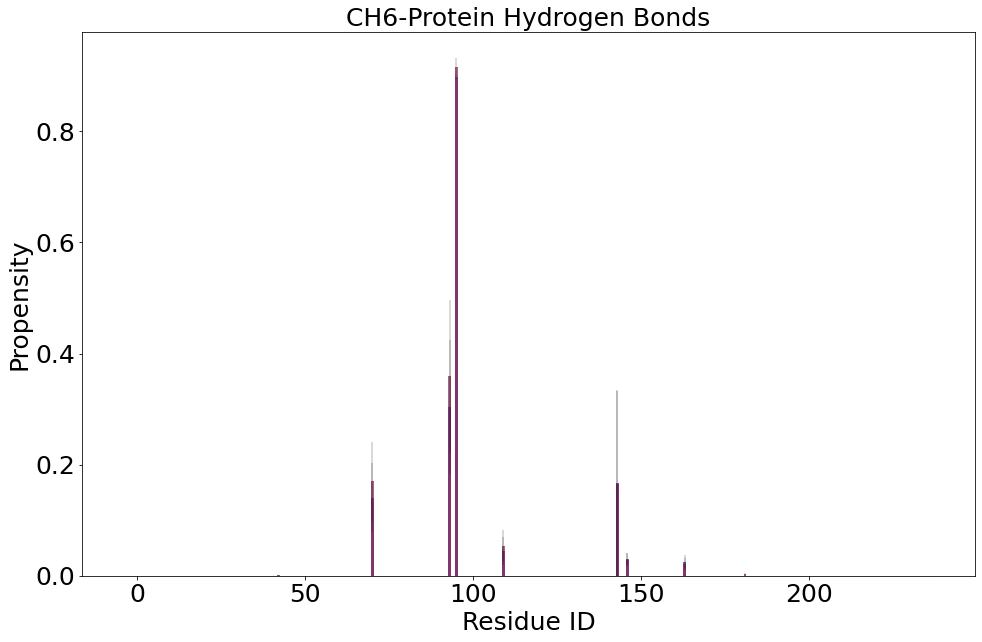

In [124]:
figure(figsize = (16,10))

bar(arange(-4.5,238.5,1)[:-1]+.5,system_avg_ch6_hb_propensities[0],color = colourScheme[0],alpha = 0.7)
bar(arange(-4.5,238.5,1)[:-1]+.5,system_avg_ch6_hb_propensities[1],color = colourScheme[1],alpha = 0.7)
errorbar(arange(-4.5,238.5,1)[:-1]+.5,system_avg_ch6_hb_propensities[0],system_sem_ch6_hb_propensities[0],fmt=".",markersize = 0.01,linewidth = .3, color = "black")
errorbar(arange(-4.5,238.5,1)[:-1]+.5,system_avg_ch6_hb_propensities[1],system_sem_ch6_hb_propensities[1],fmt=".",markersize = 0.01,linewidth = .3, color = "black")
xlabel("Residue ID",fontsize = 25)
ylabel("Propensity",fontsize = 25)
title("CH6-Protein Hydrogen Bonds",fontsize = 25) 
asdfaskufhvkasduf = xticks(fontsize = 25)
lkfahuksjrhfawkjh = yticks(fontsize = 25)



In [127]:
save("all_ch6_hbond_propensities.npy",all_ch6_hb_propensities)

Text(0.5, 1.0, 'Number of Atoms in Contact Propensity Difference: PEG - H2O (significant only)')

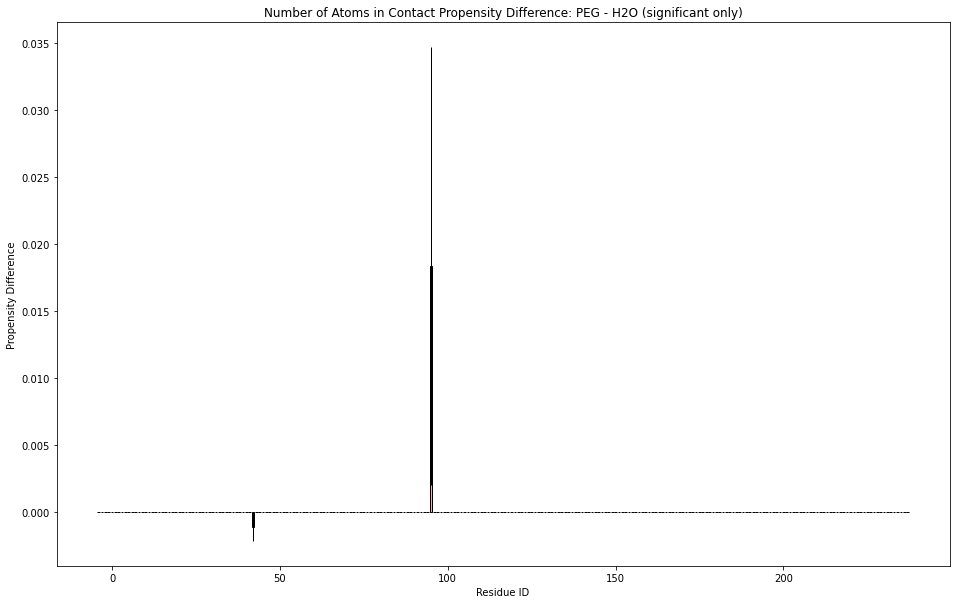

In [126]:
avgDiffBars = (system_avg_ch6_hb_propensities[1] - system_avg_ch6_hb_propensities[0])
semDiffBars = sqrt(system_sem_ch6_hb_propensities[1]**2 + system_sem_ch6_hb_propensities[0]**2)
colors =[]

for i in range(len(avgDiffBars)):
    if avgDiffBars[i] > 0:
        colors.append([1.,1-(avgDiffBars[i]/max(abs(avgDiffBars))),1-(avgDiffBars[i]/max(abs(avgDiffBars)))])
    if avgDiffBars[i] <=0:
        colors.append([1-(-avgDiffBars[i]/max(abs(avgDiffBars))),1-(-avgDiffBars[i]/max(abs(avgDiffBars))),1.])
        
# get significant only
avgSignifBars=copy(avgDiffBars)
semSignifBars=copy(semDiffBars)
for i in range(len(avgDiffBars)):
    
    if abs(semDiffBars[i]) > abs(avgDiffBars[i]):
        avgSignifBars[i] = 0
        semSignifBars[i] = 0        
        
       
        

        
figure(figsize = (16,10))

bar(arange(-4.5,238.5,1)[:-1]+.5,avgSignifBars,color = colors,edgecolor= 'black')
errorbar(arange(-4.5,238.5,1)[:-1]+.5,avgSignifBars,semSignifBars,fmt=".",markersize = 0.01,linewidth = 1, color = "black")
xlabel("Residue ID")
ylabel("Propensity Difference")
title("Number of Atoms in Contact Propensity Difference: PEG - H2O (significant only)") 
